In [238]:
!pip install torchinfo

In [239]:
!wget https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv

--2024-05-06 23:51:20--  https://github.com/pvateekul/2110531_DSDE_2023s1/raw/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv [following]
--2024-05-06 23:51:21--  https://raw.githubusercontent.com/pvateekul/2110531_DSDE_2023s1/main/code/Week05_Intro_Deep_Learning/data/GOOG.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284248 (278K) [text/plain]
Saving to: ‘GOOG.csv.5’

GOOG.csv.5          100%[===================>] 277.59K  --.-KB/s    in 0.003s  

2024-05

In [240]:
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import yfinance as yf
from itertools import product

In [241]:
start = "2014-01-01"
interval = "1d"

goog = yf.Ticker("GOOG")
goog_data = goog.history(start=start, interval=interval)
goog_data = goog_data[["Open", "High", "Low", "Close", "Volume"]]
goog_data = goog_data.dropna()

aapl = yf.Ticker("AAPL")
aapl_data = aapl.history(start=start, interval=interval)
aapl_data = aapl_data[["Open", "High", "Low", "Close", "Volume"]]
aapl_data = aapl_data.rename(columns={"Open": "aapl_open", "High": "aapl_high", "Low": "aapl_low", "Close": "aapl_close", "Volume": "aapl_volume"})

amzn = yf.Ticker("AMZN")
amzn_data = amzn.history(start=start, interval=interval)
amzn_data = amzn_data[["Open", "High", "Low", "Close", "Volume"]]
amzn_data = amzn_data.rename(columns={"Open": "amzn_open", "High": "amzn_high", "Low": "amzn_low", "Close": "amzn_close", "Volume": "amzn_volume"})
amzn_data = amzn_data.dropna()

msft = yf.Ticker("MSFT")
msft_data = msft.history(start=start, interval=interval)
msft_data = msft_data[["Open", "High", "Low", "Close", "Volume"]]
msft_data = msft_data.rename(columns={"Open": "msft_open", "High": "msft_high", "Low": "msft_low", "Close": "msft_close", "Volume": "msft_volume"})
msft_data = msft_data.dropna()

# merge all stock data
df = pd.concat([goog_data, aapl_data, amzn_data, msft_data], axis=1)
df = df.dropna()

In [242]:
# df = pd.read_csv('GOOG.csv', index_col="Date")
# df = df.drop(['Adj Close'], axis = 1)

target_col = "Close"
features = list(df.columns.difference([target_col]))

forecast_lead = 1
target = f"{target_col}_lead{forecast_lead}"

df[target] = df[target_col].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]
df

,Open,High,Low,Close,Volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,27.782366,27.839401,27.603037,27.724083,73129082,17.376396,17.418611,17.261946,17.296656,234684800,...,19.968000,19.701000,19.898500,42756000,31.392749,31.434777,31.182624,31.233055,30632200,27.521841
2014-01-03 00:00:00-05:00,27.770908,27.818977,27.520098,27.521841,66917888,17.288215,17.314481,16.899522,16.916721,392467600,...,20.135500,19.811001,19.822001,44204000,31.266675,31.283485,30.762371,31.022928,31134800,27.828691
2014-01-06 00:00:00-05:00,27.721344,27.867046,27.557707,27.828691,71037271,16.806332,17.098710,16.685940,17.008965,412610800,...,19.850000,19.421000,19.681499,63412000,30.972507,31.006128,30.350537,30.367348,43603700,28.365179
2014-01-07 00:00:00-05:00,28.019974,28.385853,27.924334,28.365179,102486711,17.021165,17.072448,16.821034,16.887327,317209200,...,19.923500,19.714500,19.901501,38320000,30.535449,30.669930,30.434587,30.602688,35802800,28.424210
2014-01-08 00:00:00-05:00,28.543015,28.575891,28.226450,28.424210,90036218,16.848863,17.059939,16.845112,16.994272,258529600,...,20.150000,19.802000,20.096001,46330000,30.258075,30.375744,29.905065,30.056353,59971700,28.150484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29 00:00:00-04:00,170.770004,171.380005,167.059998,167.899994,35914600,173.369995,176.029999,173.100006,173.500000,68169400,...,183.529999,179.389999,180.960007,54063900,405.250000,406.320007,399.190002,402.250000,19582100,164.639999
2024-04-30 00:00:00-04:00,167.380005,169.869995,164.500000,164.639999,29420800,173.330002,174.990005,170.000000,170.330002,65934800,...,182.990005,174.800003,175.000000,94639800,401.489990,402.160004,389.170013,389.329987,28781400,165.570007
2024-05-01 00:00:00-04:00,166.179993,168.809998,164.899994,165.570007,25223200,169.580002,172.710007,169.110001,169.300003,50383100,...,185.149994,176.559998,179.000000,94645100,392.609985,401.720001,390.309998,394.940002,23562500,168.460007


<Axes: xlabel='Date'>

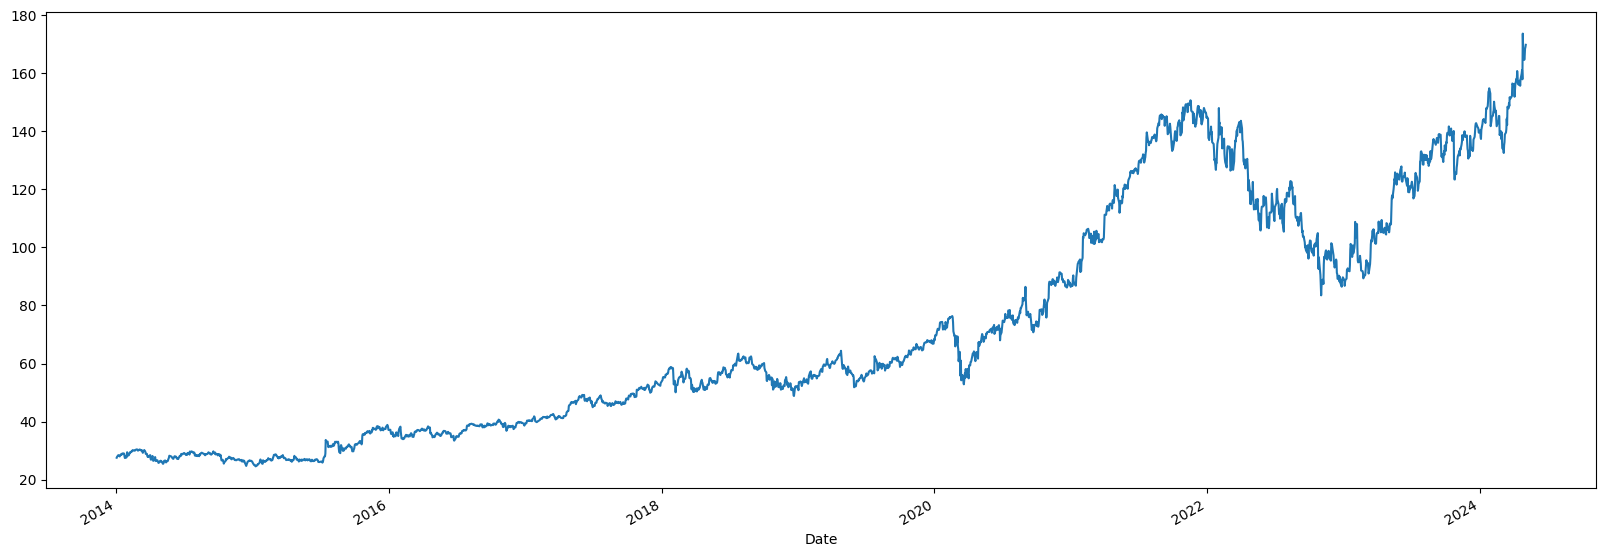

In [243]:
df[target].plot(figsize=(20, 7))

In [244]:
val_start = "2022-01-01"
test_start = "2023-01-01"


df_train = df.loc[:val_start].copy()
df_val = df.loc[val_start:test_start].copy()
df_test = df.loc[test_start:].copy()

In [245]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_val[c] = (df_val[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev
df_train.head()

,Open,High,Low,Close,Volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,...,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,-0.951329,-0.957670,-0.948136,-0.953076,1.885143,-0.925385,-0.927554,-0.925188,-0.927534,0.955638,...,-1.054327,-1.052662,-1.052865,-0.933088,-0.980070,-0.983048,-0.978796,-0.981979,0.020770,-0.959814
2014-01-03 00:00:00-05:00,-0.951702,-0.958329,-0.950860,-0.959655,1.574411,-0.927595,-0.930133,-0.934380,-0.937050,2.786950,...,-1.051142,-1.050522,-1.054337,-0.899837,-0.981669,-0.984950,-0.984178,-0.984643,0.055427,-0.949849
2014-01-06 00:00:00-05:00,-0.953317,-0.956778,-0.949625,-0.949672,1.780494,-0.939675,-0.935477,-0.939797,-0.934740,3.020742,...,-1.056571,-1.058111,-1.057040,-0.458759,-0.985401,-0.988436,-0.989452,-0.992953,0.915239,-0.932427
2014-01-07 00:00:00-05:00,-0.943590,-0.940040,-0.937584,-0.932218,3.353837,-0.934290,-0.936128,-0.936371,-0.937786,1.913460,...,-1.055173,-1.052399,-1.052807,-1.034953,-0.990946,-0.992661,-0.988375,-0.989970,0.377316,-0.930510
2014-01-08 00:00:00-05:00,-0.926553,-0.933909,-0.927661,-0.930298,2.730968,-0.938609,-0.936438,-0.935760,-0.935108,1.232394,...,-1.050867,-1.050697,-1.049065,-0.851018,-0.994465,-0.996358,-0.995157,-0.996895,2.043918,-0.939399


In [246]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [247]:
df.corr().style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1
Open,1.000000,0.999816,0.999801,0.999569,-0.328756,0.962278,0.961979,0.962669,0.962190,-0.540539,0.906492,0.906884,0.906325,0.906443,-0.201351,0.977399,0.977094,0.977386,0.977070,-0.149449,0.998846
High,0.999816,1.000000,0.999771,0.999799,-0.326060,0.963177,0.963021,0.963615,0.963270,-0.539534,0.906390,0.906990,0.906290,0.906601,-0.198161,0.977902,0.977766,0.977950,0.977784,-0.146059,0.999081
Low,0.999801,0.999771,1.000000,0.999818,-0.334010,0.961670,0.961419,0.962241,0.961798,-0.543428,0.906390,0.906858,0.906509,0.906667,-0.205947,0.977175,0.976923,0.977372,0.977090,-0.155011,0.999088
Close,0.999569,0.999799,0.999818,1.000000,-0.330928,0.962193,0.962073,0.962797,0.962554,-0.541931,0.906227,0.906876,0.906386,0.906818,-0.202647,0.977447,0.977354,0.977688,0.977625,-0.151390,0.999240
Volume,-0.328756,-0.326060,-0.334010,-0.330928,1.000000,-0.305500,-0.304053,-0.307791,-0.306331,0.568464,-0.307716,-0.305756,-0.312126,-0.309536,0.489748,-0.314651,-0.312626,-0.317409,-0.315449,0.569545,-0.330904
aapl_open,0.962278,0.963177,0.961670,0.962193,-0.305500,1.000000,0.999882,0.999864,0.999712,-0.514191,0.862589,0.863756,0.861622,0.862544,-0.207357,0.980071,0.980390,0.979718,0.979884,-0.111645,0.961735
aapl_high,0.961979,0.963021,0.961419,0.962073,-0.304053,0.999882,1.000000,0.999829,0.999862,-0.511859,0.862830,0.864149,0.861904,0.862969,-0.204739,0.979799,0.980246,0.979481,0.979765,-0.109056,0.961599
aapl_low,0.962669,0.963615,0.962241,0.962797,-0.307791,0.999864,0.999829,1.000000,0.999867,-0.517282,0.861975,0.863198,0.861215,0.862164,-0.210626,0.980416,0.980771,0.980219,0.980408,-0.115269,0.962343
aapl_close,0.962190,0.963270,0.961798,0.962554,-0.306331,0.999712,0.999862,0.999867,1.000000,-0.514792,0.862235,0.863601,0.861505,0.862672,-0.208015,0.979995,0.980473,0.979830,0.980196,-0.112729,0.962049
aapl_volume,-0.540539,-0.539534,-0.543428,-0.541931,0.568464,-0.514191,-0.511859,-0.517282,-0.514792,1.000000,-0.497387,-0.495958,-0.500518,-0.498718,0.353725,-0.524157,-0.522612,-0.526287,-0.524661,0.480895,-0.542239


In [248]:
correlation = df.corr()[target]
correlation = correlation[abs(correlation) > 0.9]
correlation = correlation[correlation.index != target]
correlation

Open          0.998846
High          0.999081
Low           0.999088
Close         0.999240
aapl_open     0.961735
aapl_high     0.961599
aapl_low      0.962343
aapl_close    0.962049
amzn_open     0.906010
amzn_high     0.906685
amzn_low      0.906203
amzn_close    0.906603
msft_open     0.977289
msft_high     0.977185
msft_low      0.977528
msft_close    0.977432
Name: Close_lead1, dtype: float64

In [249]:

features = correlation.index.tolist()
# features = ['Open','High','Low','Close']
features

['Open',
 'High',
 'Low',
 'Close',
 'aapl_open',
 'aapl_high',
 'aapl_low',
 'aapl_close',
 'amzn_open',
 'amzn_high',
 'amzn_low',
 'amzn_close',
 'msft_open',
 'msft_high',
 'msft_low',
 'msft_close']

In [250]:
i = 4
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-0.9517, -0.9583, -0.9509, -0.9597, -0.9276, -0.9301, -0.9344, -0.9371,
         -1.0522, -1.0511, -1.0505, -1.0543, -0.9817, -0.9849, -0.9842, -0.9846],
        [-0.9533, -0.9568, -0.9496, -0.9497, -0.9397, -0.9355, -0.9398, -0.9347,
         -1.0546, -1.0566, -1.0581, -1.0570, -0.9854, -0.9884, -0.9895, -0.9930],
        [-0.9436, -0.9400, -0.9376, -0.9322, -0.9343, -0.9361, -0.9364, -0.9378,
         -1.0554, -1.0552, -1.0524, -1.0528, -0.9909, -0.9927, -0.9884, -0.9900],
        [-0.9266, -0.9339, -0.9277, -0.9303, -0.9386, -0.9364, -0.9358, -0.9351,
         -1.0521, -1.0509, -1.0507, -1.0491, -0.9945, -0.9964, -0.9952, -0.9969]])


In [251]:
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([1, 4, 16])
tensor([[[-0.9830, -0.9828, -0.9775, -0.9802, -0.7063, -0.7015, -0.7019,
          -0.6967, -1.1133, -1.1132, -1.1114, -1.1128, -0.8526, -0.8572,
          -0.8541, -0.8570],
         [-0.9808, -0.9807, -0.9727, -0.9773, -0.6939, -0.6961, -0.6972,
          -0.7024, -1.1128, -1.1142, -1.1137, -1.1134, -0.8562, -0.8575,
          -0.8534, -0.8583],
         [-0.9778, -0.9846, -0.9752, -0.9784, -0.7002, -0.6997, -0.6951,
          -0.6946, -1.1142, -1.1158, -1.1132, -1.1148, -0.8581, -0.8573,
          -0.8553, -0.8552],
         [-0.9782, -0.9839, -0.9759, -0.9761, -0.6927, -0.6980, -0.6938,
          -0.6950, -1.1121, -1.1096, -1.1091, -1.1099, -0.8530, -0.8550,
          -0.8516, -0.8546]]])


In [252]:
torch.manual_seed(101)

batch_size = 32
sequence_length = 120

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [253]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [254]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, filter, kernel_size=3, stride=1, padding=1):
        super(ResBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, filter, kernel_size, stride, padding)
        self.conv2 = torch.nn.Conv1d(filter, filter, kernel_size, stride, padding)
        self.linear = torch.nn.Linear(filter, out_channels)
        self.relu = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.bn2 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.dropout = nn.Dropout(0.2)
        # intialise weights of the attention mechanism
        self.weight = nn.Parameter(torch.zeros(1)).to(device)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.dropout(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.weight*out
        out += x.view(x.size(0), -1)
        return out

In [255]:
class ResNLS(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_layer, num_layer, num_feature=4, filter=64, kernel_size=3, dropout=0.2, bidirectional=False):
        super(ResNLS, self).__init__()
        self.resblock = torch.nn.ModuleList([ResBlock(in_channels, in_channels, filter) for i in range(num_feature)])
        self.bidirectional=bidirectional
        self.num_layers = num_layer
        self.hidden_layer = hidden_layer
        self.lstm = torch.nn.LSTM(num_feature, hidden_layer, num_layer, batch_first=True,dropout=dropout,bidirectional=bidirectional)
        self.linear = torch.nn.Linear(hidden_layer, out_channels)


    def forward(self, x):
        batch_size = x.size(0)
        out = torch.split(x, 1, 2)
        out_res = []

        for i in range(len(out)):
            out_res.append(self.resblock[i](out[i]))
        out = torch.stack(out_res, 2)

        h0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        _, (hn, _) = self.lstm(out, (h0, c0))
        out = self.linear(hn[-1]).flatten()
        return out

In [256]:
# Init from paper
num_consecutive_days = sequence_length
days_pred = 1
num_lstm_hiddensize = 64
lstm_layers = 1
num_features = len(features)
filters = 64
kernel_size = 3
dropout_lstm = 0.2
bidirectional = False
model = ResNLS(num_consecutive_days,
               days_pred,
               num_lstm_hiddensize,
               lstm_layers,
               num_features,
               filters,
               kernel_size,
               dropout_lstm,
               bidirectional)
model.to(device)
summary(model, input_size=(batch_size, num_consecutive_days, num_features))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Layer (type:depth-idx)                   Output Shape              Param #
ResNLS                                   [32]                      --
├─ModuleList: 1-1                        --                        --
│    └─ResBlock: 2-1                     [32, 120]                 --
│    │    └─Conv1d: 3-1                  [32, 64, 1]               23,104
│    │    └─ReLU: 3-2                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-3             [32, 64, 1]               128
│    │    └─Dropout: 3-4                 [32, 64, 1]               --
│    │    └─Conv1d: 3-5                  [32, 64, 1]               12,352
│    │    └─ReLU: 3-6                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-7             [32, 64, 1]               128
│    │    └─Linear: 3-8                  [32, 120]                 7,800
│    └─ResBlock: 2-2                     [32, 120]                 --
│    │    └─Conv1d: 3-9                  [32, 64, 1]               23,10

In [257]:
parameters_to_decay = []
for name, param in model.named_parameters():
    if 'conv1' in name or 'conv2' in name:
        parameters_to_decay.append(param)

weight_decay = 1e-4
learning_rate = 1e-3
optimizer = torch.optim.Adam([{'params': parameters_to_decay, 'weight_decay': weight_decay},
                              {'params': model.lstm.parameters()},
                              {'params': model.linear.parameters()}],
                             lr=learning_rate)
loss_function = nn.MSELoss()

In [258]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model.pth')
        print('Save new best model')
    return best_val_loss , avg_loss

In [259]:
best_val_loss = torch.inf
train_losses = []
val_losses = []
for ix_epoch in tqdm(range(200)):
    print(f"Epoch {ix_epoch}\n---------")
    train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    best_val_loss,avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
    val_losses.append(avg_loss)
    print()

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0
---------
Train loss: 0.19449775274251663
Test loss: 0.06395833217538893
Save new best model

Epoch 1
---------
Train loss: 0.006014062088012459
Test loss: 0.08642324013635516

Epoch 2
---------
Train loss: 0.0037820907309651375
Test loss: 0.06846772693097591

Epoch 3
---------
Train loss: 0.003528319853579714
Test loss: 0.07561271521262825

Epoch 4
---------
Train loss: 0.0034240398459905196
Test loss: 0.1252974127419293

Epoch 5
---------
Train loss: 0.003196583563713209
Test loss: 0.059045921079814434
Save new best model

Epoch 6
---------
Train loss: 0.003008088207848015
Test loss: 0.06680476828478277

Epoch 7
---------
Train loss: 0.0025113517222630365
Test loss: 0.0593650380615145

Epoch 8
---------
Train loss: 0.002410364799231054
Test loss: 0.05422605574131012
Save new best model

Epoch 9
---------
Train loss: 0.0022728145547536395
Test loss: 0.0509819402359426
Save new best model

Epoch 10
---------
Train loss: 0.002070200728392968
Test loss: 0.03297052322886884
Save n

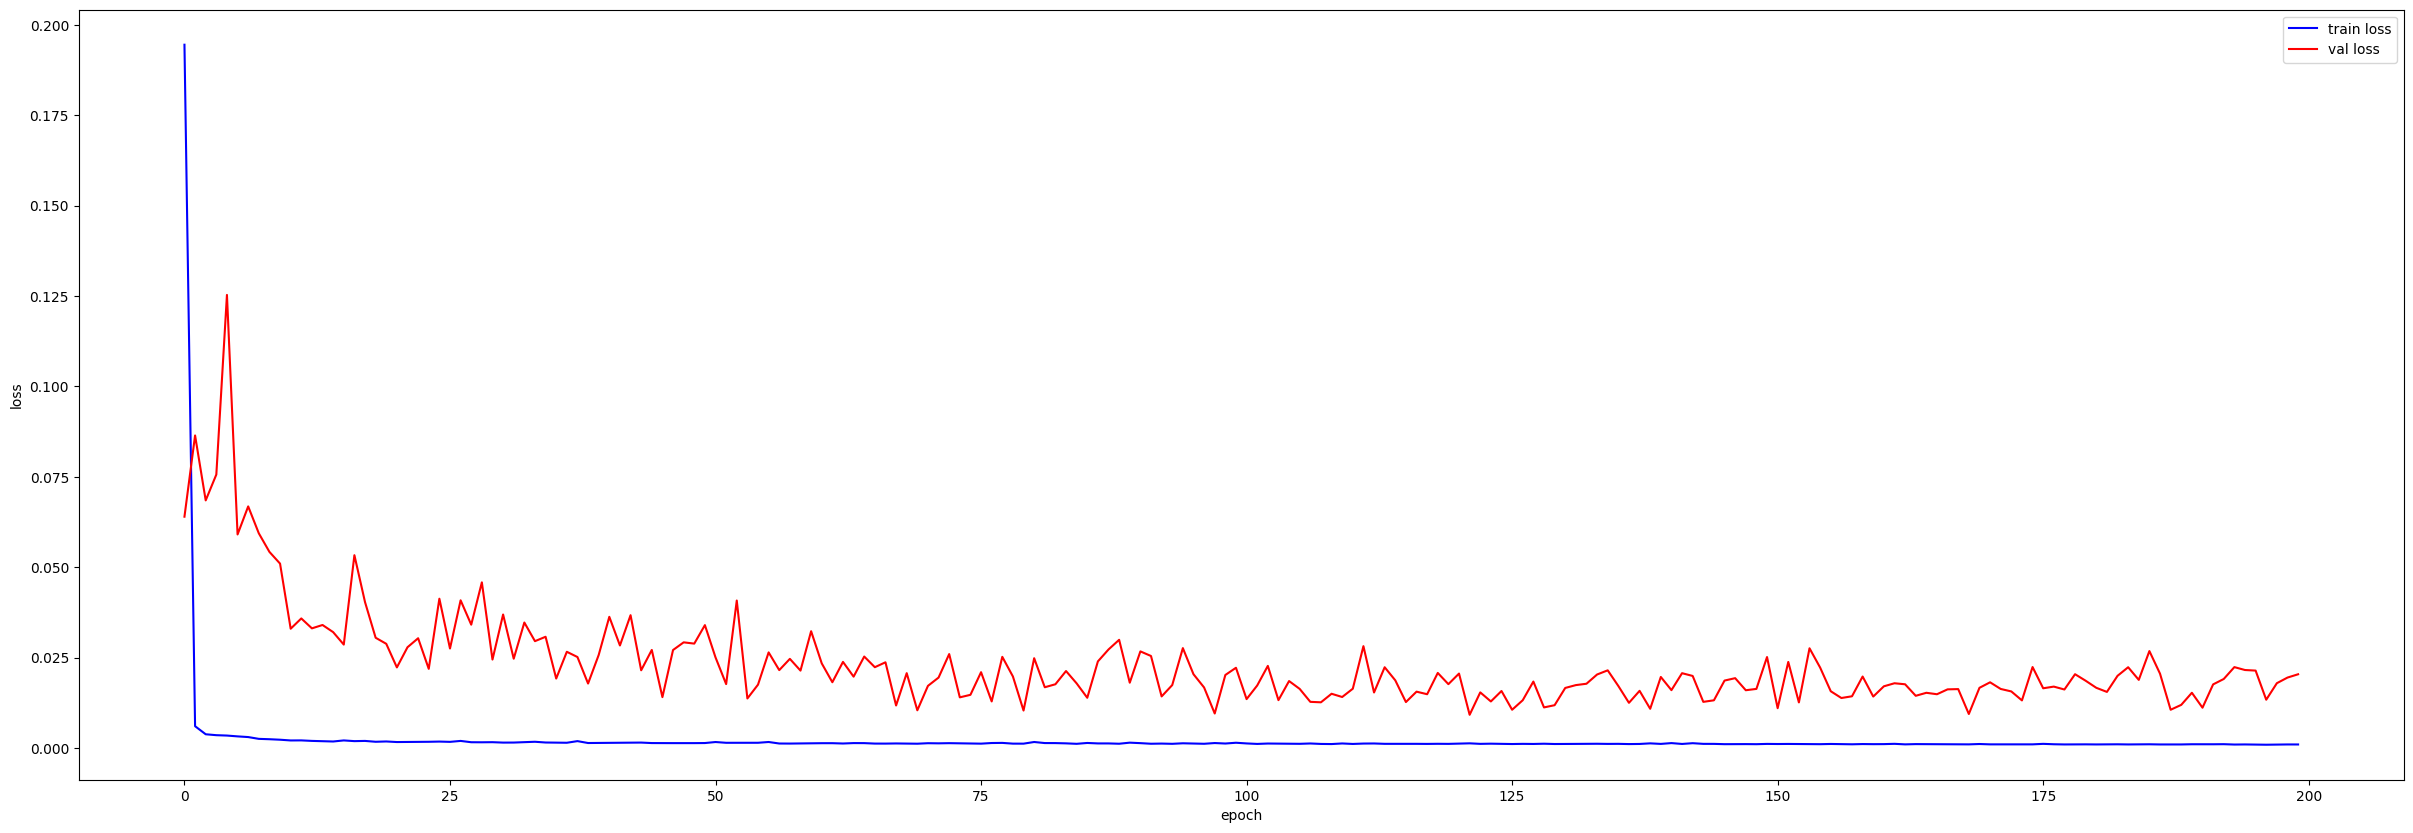

In [260]:
def plot_losses(train_loss,val_loss):
  plt.figure(figsize=(30, 10))
  plt.plot(train_loss,color="blue",label="train loss")
  plt.plot(val_loss,color="red",label="val loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

plot_losses(train_losses,val_losses)

In [261]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)
    return output

In [262]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"

df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = None
df_test_out = pd.DataFrame()
df_test_out[target] = df_test[target]
df_test_out[ystar_col] = df_test[ystar_col]

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

for c in df_test_out.columns:
    df_test_out[c] = df_test_out[c] * target_stdev + target_mean

print(df_test_out[[target, ystar_col]])

                           Close_lead1  Model forecast
Date                                                  
2023-01-03 00:00:00-05:00    88.709999       93.678299
2023-01-04 00:00:00-05:00    86.769997       93.118362
2023-01-05 00:00:00-05:00    88.160004       90.106529
2023-01-06 00:00:00-05:00    88.800003       90.566010
2023-01-09 00:00:00-05:00    89.239998       92.487083
...                                ...             ...
2024-04-29 00:00:00-04:00   164.639999      160.990341
2024-04-30 00:00:00-04:00   165.570007      163.131775
2024-05-01 00:00:00-04:00   168.460007      158.916550
2024-05-02 00:00:00-04:00   168.990005      163.448547
2024-05-03 00:00:00-04:00   169.830002      164.387985

[336 rows x 2 columns]


In [263]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
def MASE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y) / torch.mean(torch.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def sharp_ratio(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean((pred - y) / torch.std(y)))

print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))

MASE = 2.2899137698620513
RMSE = 4.247993100143995
SMAPE = 2.865702842846121
MAE = 3.525204590388707
sharp_ratio = -0.15681808377263262


In [264]:
fig = px.line(df_out, labels={'value': target, 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [265]:
fig = px.line(df_test_out[[target, ystar_col]], labels={'value': target, 'created_at': 'Date'})
# fig.add_vline(x=val_start, line_width=4, line_dash="dash")
# fig.add_vline(x=test_start, line_width=4, line_dash="dash")

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [266]:
param_grid = {
    'dropout_lstm': [0.2],
    'weight_decay': [1e-4, 1e-5],
    'learning_rate': [1e-3],
    'num_lstm_hiddensize': [64],
    'lstm_layers': [1],
    'filters': [64],
    'kernel_size': [3],
    'bidirectional': [False],
    'num_consecutive_days': [60],
    'days_pred': [1],
    'num_features': [len(features)],
    'batch_size': [32]
}

param_combinations = list(product(*param_grid.values()))
len(param_combinations)

2

In [267]:

def grid_search(param_combinations):
    best_val_loss_sin = torch.inf
    best_val_loss_list = []
    best_train_loss_list = []
    best_params = None
    best_val_loss = torch.inf
    best_model = None
    best_train_dataloader = None
    best_val_dataloader = None
    best_test_dataloader = None

    for params in tqdm(param_combinations):
        print(params)
        dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size = params
        model = ResNLS(num_consecutive_days,
                       days_pred,
                       num_lstm_hiddensize,
                       lstm_layers,
                       num_features,
                       filters,
                       kernel_size,
                       dropout_lstm,
                       bidirectional)
        model.to(device)

        train_dataset = SequenceDataset(
            df_train,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        val_dataset = SequenceDataset(
            df_val,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        test_dataset = SequenceDataset(
            df_test,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        parameters_to_decay = []
        for name, param in model.named_parameters():
            if 'conv1' in name or 'conv2' in name:
                parameters_to_decay.append(param)

        optimizer = torch.optim.Adam([
            {'params': parameters_to_decay, 'weight_decay': weight_decay},
            {'params': model.lstm.parameters()},
            {'params': model.linear.parameters()}
        ], lr=learning_rate)

        loss_function = nn.MSELoss()

        train_losses = []
        val_losses = []
        for ix_epoch in range(150):
            print(f"Epoch {ix_epoch}\n---------")
            train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
            best_val_loss, avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
            val_losses.append(avg_loss)
            print()

        if best_val_loss < best_val_loss_sin:
            best_params = params
            best_val_loss_list = val_losses
            best_train_loss_list = train_losses
            best_val_loss_sin = best_val_loss
            best_train_dataloader = train_loader
            best_val_dataloader = val_loader
            best_test_dataloader = test_loader
            best_model = model

    print(f"Best params: {best_params}")
    print(f"Best val loss: {best_val_loss_sin}")
    plot_losses(best_train_loss_list, best_val_loss_list)

    ystar_col = "Model forecast"

    df_train[ystar_col] = predict(best_train_dataloader, best_model).numpy()
    df_val[ystar_col] = predict(best_val_dataloader, best_model).numpy()
    df_test[ystar_col] = predict(best_test_dataloader, best_model).numpy()

    df_out = None
    df_test_out = pd.DataFrame()
    df_test_out[target] = df_test[target]
    df_test_out[ystar_col] = df_test[ystar_col]

    df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_stdev + target_mean

    for c in df_test_out.columns:
        df_test_out[c] = df_test_out[c] * target_stdev + target_mean

    print(df_test_out[[target, ystar_col]])


    print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
    print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
    print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
    print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
    print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))

    plt.figure(figsize=(20, 7))
    plt.plot(df_test_out[target], label='True')
    plt.plot(df_test_out[ystar_col], label='Forecast')
    plt.legend()

    return best_params

def copy_from_best(best_params):
    dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size = best_params
    param_grid = {
      'dropout_lstm': [dropout_lstm],
      'weight_decay': [weight_decay],
      'learning_rate': [learning_rate],
      'num_lstm_hiddensize': [num_lstm_hiddensize],
      'lstm_layers': [lstm_layers],
      'filters': [filters],
      'kernel_size': [kernel_size],
      'bidirectional': [bidirectional],
      'num_consecutive_days': [num_consecutive_days],
      'days_pred': [days_pred],
      'num_features': [num_features],
      'batch_size': [batch_size]
    }
    return param_grid


In [268]:
param_grid = {
    'dropout_lstm': [0.2],
    'weight_decay': [1e-4, 1e-5],
    'learning_rate': [1e-3],
    'num_lstm_hiddensize': [64],
    'lstm_layers': [1],
    'filters': [64],
    'kernel_size': [3],
    'bidirectional': [False],
    'num_consecutive_days': [60],
    'days_pred': [1],
    'num_features': [len(features)],
    'batch_size': [32]
}
# param_combinations = list(product(*param_grid.values()))[0]

  0%|          | 0/2 [00:00<?, ?it/s]

(0.2, 0.0001, 0.001, 64, 1, 64, 3, False, 60, 1, 16, 32)
Epoch 0
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.18768055941022577
Test loss: 0.11829753685742617
Save new best model

Epoch 1
---------
Train loss: 0.004975709210460384
Test loss: 0.07793225813657045
Save new best model

Epoch 2
---------
Train loss: 0.003622222856234109
Test loss: 0.12569465907290578

Epoch 3
---------
Train loss: 0.003054621457565753
Test loss: 0.06904746498912573
Save new best model

Epoch 4
---------
Train loss: 0.0029552158038501464
Test loss: 0.1055331495590508

Epoch 5
---------
Train loss: 0.002526557113650063
Test loss: 0.09000300616025925

Epoch 6
---------
Train loss: 0.002385503642948433
Test loss: 0.10819377517327666

Epoch 7
---------
Train loss: 0.0022830752099657226
Test loss: 0.13282339135184884

Epoch 8
---------
Train loss: 0.0022071041212978937
Test loss: 0.10219297790899873

Epoch 9
---------
Train loss: 0.0022179405380498675
Test loss: 0.08751729782670736

Epoch 10
---------
Train loss: 0.0019120773945432452
Test loss: 0.10057664848864079

Epoch 11
---------
Train loss: 0.00195690

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.18540071494995602
Test loss: 0.07827681372873485

Epoch 1
---------
Train loss: 0.006149414631109389
Test loss: 0.06862499378621578

Epoch 2
---------
Train loss: 0.004149495431828121
Test loss: 0.07362860534340143

Epoch 3
---------
Train loss: 0.003833071184566333
Test loss: 0.07716305926442146

Epoch 4
---------
Train loss: 0.003224436875565776
Test loss: 0.0493142195045948

Epoch 5
---------
Train loss: 0.002975926934076207
Test loss: 0.09610575996339321

Epoch 6
---------
Train loss: 0.0026148459005598274
Test loss: 0.07592415390536189

Epoch 7
---------
Train loss: 0.0024938233758485507
Test loss: 0.12520336639136076

Epoch 8
---------
Train loss: 0.002642379870401725
Test loss: 0.08820039127022028

Epoch 9
---------
Train loss: 0.0023961025049969082
Test loss: 0.08846732042729855

Epoch 10
---------
Train loss: 0.0020941808017798597
Test loss: 0.053937884513288736

Epoch 11
---------
Train loss: 0.0021945684409094236
Test loss: 0.11013669706881046

Epoch 12
-------

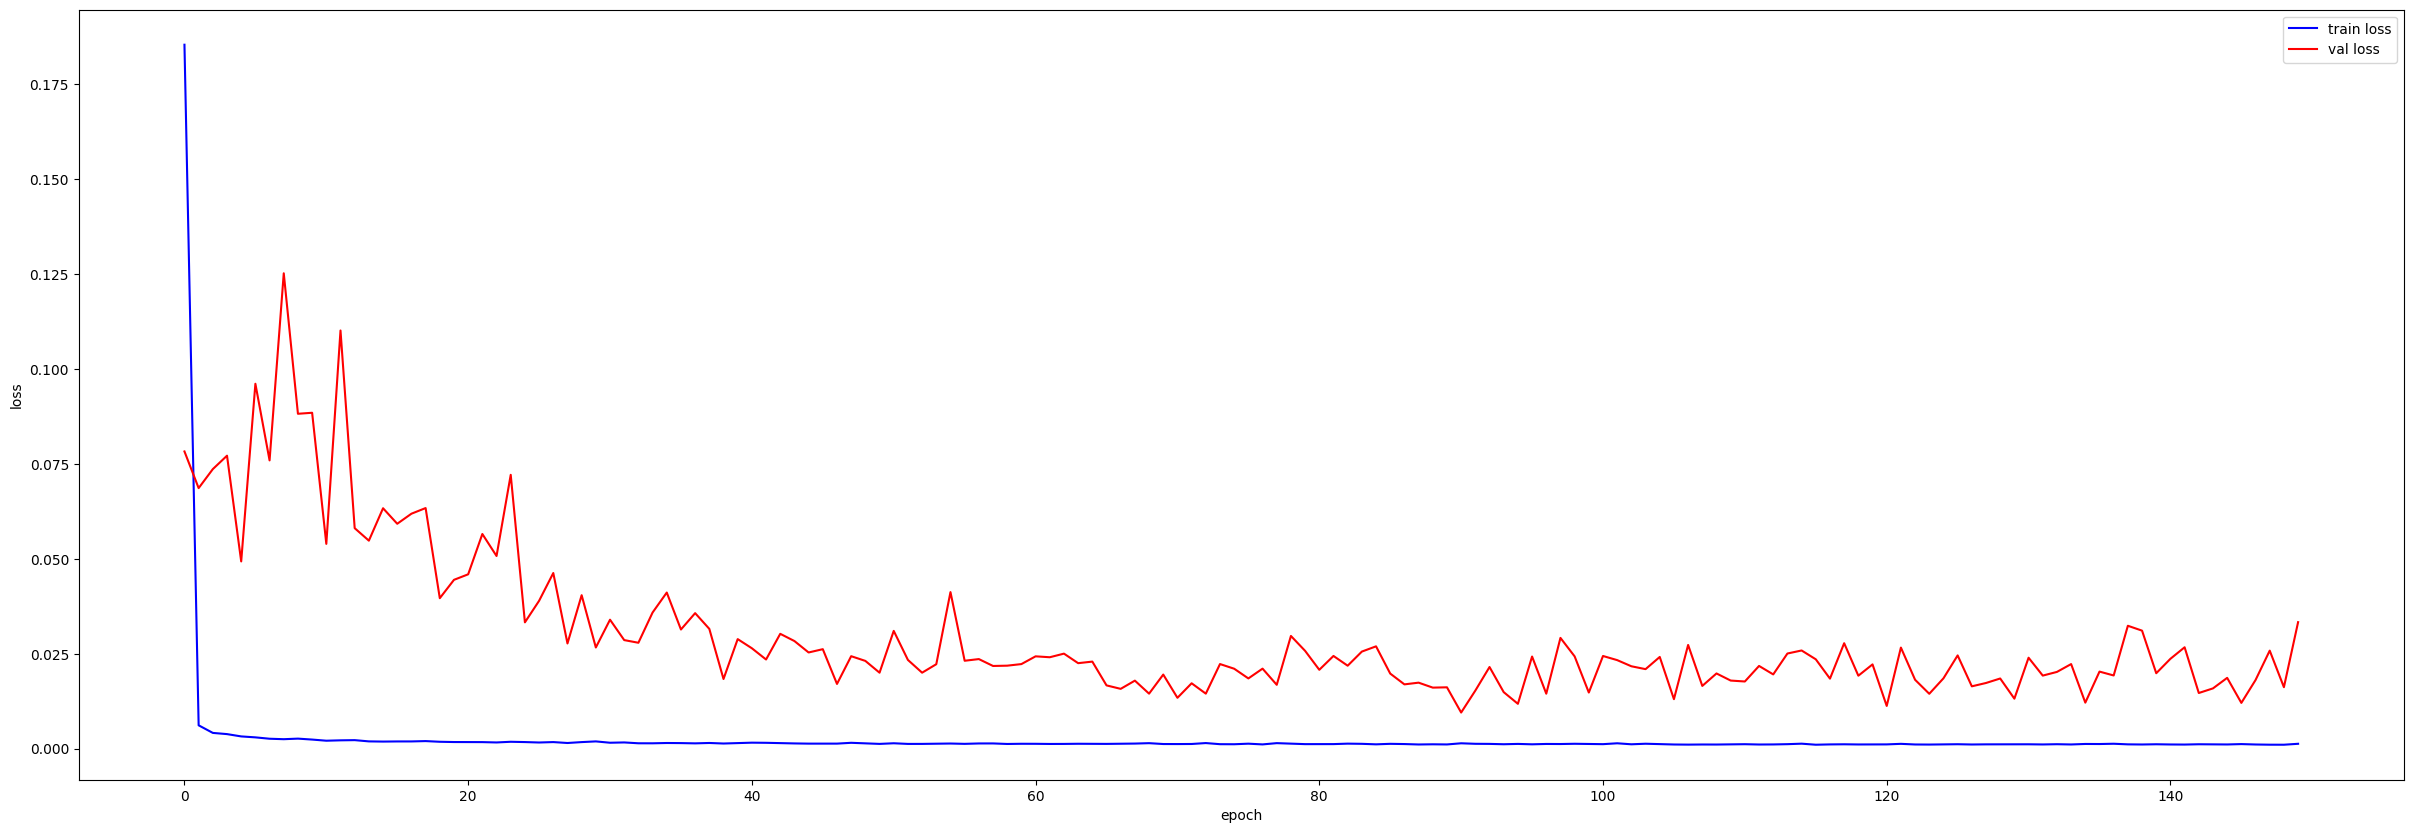

                           Close_lead1  Model forecast
Date                                                  
2023-01-03 00:00:00-05:00    88.709999       91.442291
2023-01-04 00:00:00-05:00    86.769997       90.985825
2023-01-05 00:00:00-05:00    88.160004       88.673531
2023-01-06 00:00:00-05:00    88.800003       88.703537
2023-01-09 00:00:00-05:00    89.239998       90.663666
...                                ...             ...
2024-04-29 00:00:00-04:00   164.639999      161.708221
2024-04-30 00:00:00-04:00   165.570007      159.419281
2024-05-01 00:00:00-04:00   168.460007      160.575089
2024-05-02 00:00:00-04:00   168.990005      161.328278
2024-05-03 00:00:00-04:00   169.830002      161.196701

[336 rows x 2 columns]
MASE = 3.326413098342893
RMSE = 5.150391961068865
SMAPE = 3.525231732029812
MAE = 4.432887531462169
sharp_ratio = -0.20428496271960256


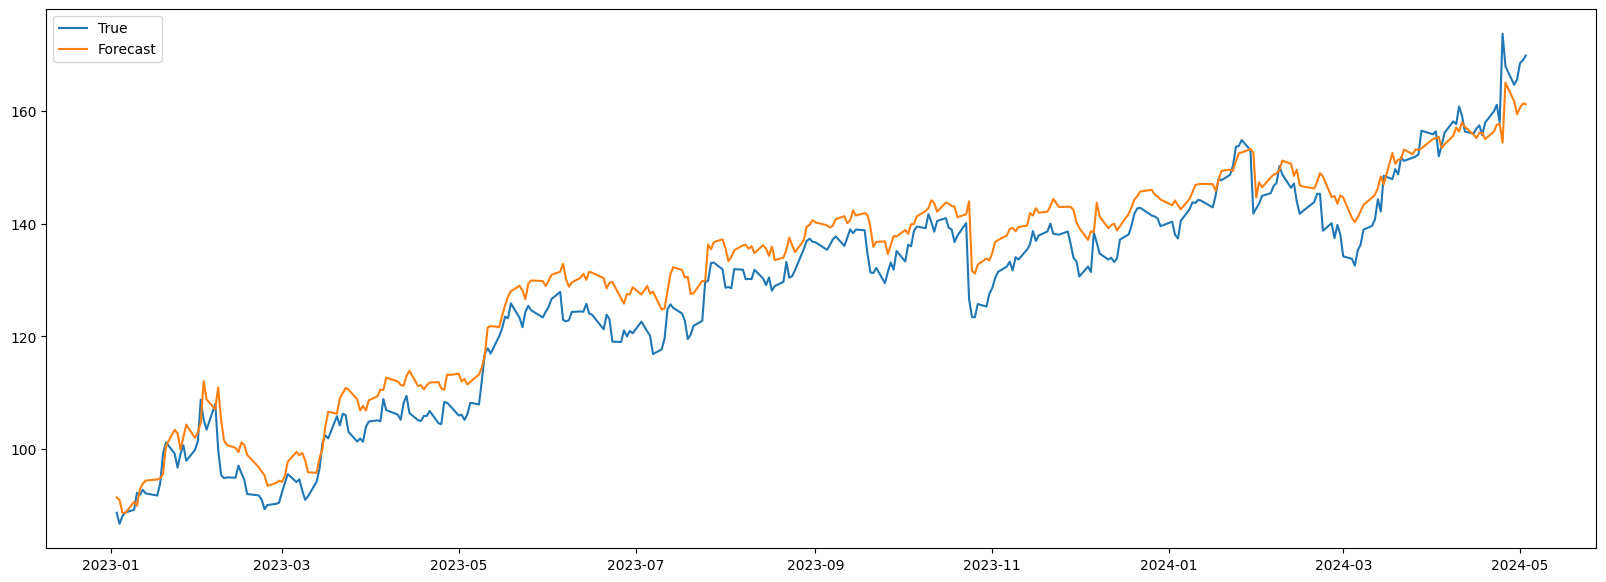

In [269]:
param_grid = copy_from_best(list(product(*param_grid.values()))[0])
param_grid['weight_decay'] = [1e-4, 1e-5]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

  0%|          | 0/3 [00:00<?, ?it/s]

(0.2, 1e-05, 0.001, 64, 1, 64, 3, False, 30, 1, 16, 32)
Epoch 0
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.12938153060034863
Test loss: 0.05760455038398504
Save new best model

Epoch 1
---------
Train loss: 0.004750649938138113
Test loss: 0.05375837255269289
Save new best model

Epoch 2
---------
Train loss: 0.0035694690923842175
Test loss: 0.03469374333508313
Save new best model

Epoch 3
---------
Train loss: 0.003393322120361503
Test loss: 0.06957361521199346

Epoch 4
---------
Train loss: 0.003001061014993678
Test loss: 0.046052426332607865

Epoch 5
---------
Train loss: 0.002569190159048294
Test loss: 0.042868335265666246

Epoch 6
---------
Train loss: 0.0023976649159550786
Test loss: 0.04016702133230865

Epoch 7
---------
Train loss: 0.0022860150423920935
Test loss: 0.03968053963035345

Epoch 8
---------
Train loss: 0.002154270057669944
Test loss: 0.04366881866008043

Epoch 9
---------
Train loss: 0.0026269711818294747
Test loss: 0.03795482078567147

Epoch 10
---------
Train loss: 0.001895406896004542
Test loss: 0.027977488236501813
Save new best model

Epoch 11
---------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.19543221223330687
Test loss: 0.025798393646255136

Epoch 1
---------
Train loss: 0.007557700779880323
Test loss: 0.045205125119537115

Epoch 2
---------
Train loss: 0.004455569767511435
Test loss: 0.03322352096438408

Epoch 3
---------
Train loss: 0.003746632161358046
Test loss: 0.042470058193430305

Epoch 4
---------
Train loss: 0.003217795056231793
Test loss: 0.030752706341445446

Epoch 5
---------
Train loss: 0.0028235662510500306
Test loss: 0.023254850646480918

Epoch 6
---------
Train loss: 0.0028150984536974674
Test loss: 0.022904499201104045

Epoch 7
---------
Train loss: 0.0025196852557922878
Test loss: 0.024345236364752054

Epoch 8
---------
Train loss: 0.0024282015686381666
Test loss: 0.04381172452121973

Epoch 9
---------
Train loss: 0.002165117461810864
Test loss: 0.03473262442275882

Epoch 10
---------
Train loss: 0.0021496876503252203
Test loss: 0.019091921392828226

Epoch 11
---------
Train loss: 0.0022577062528210856
Test loss: 0.032420648727566004

Epoch 

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.1562314188137414
Test loss: 0.07866197358816862

Epoch 1
---------
Train loss: 0.006100130746037596
Test loss: 0.13107355078682303

Epoch 2
---------
Train loss: 0.004083242954774981
Test loss: 0.07315791491419077

Epoch 3
---------
Train loss: 0.0036601887568683614
Test loss: 0.05992619460448623

Epoch 4
---------
Train loss: 0.0031542602412786987
Test loss: 0.09578108554705977

Epoch 5
---------
Train loss: 0.0028500247604420614
Test loss: 0.10696090804412961

Epoch 6
---------
Train loss: 0.0026030322751178156
Test loss: 0.09056311007589102

Epoch 7
---------
Train loss: 0.0025940411373056352
Test loss: 0.07710041664540768

Epoch 8
---------
Train loss: 0.002370243292442331
Test loss: 0.05410655005834997

Epoch 9
---------
Train loss: 0.0024177072355375875
Test loss: 0.1016354188323021

Epoch 10
---------
Train loss: 0.0023629089562399756
Test loss: 0.05046196887269616

Epoch 11
---------
Train loss: 0.0021564480155662055
Test loss: 0.041935220593586564

Epoch 12
-----

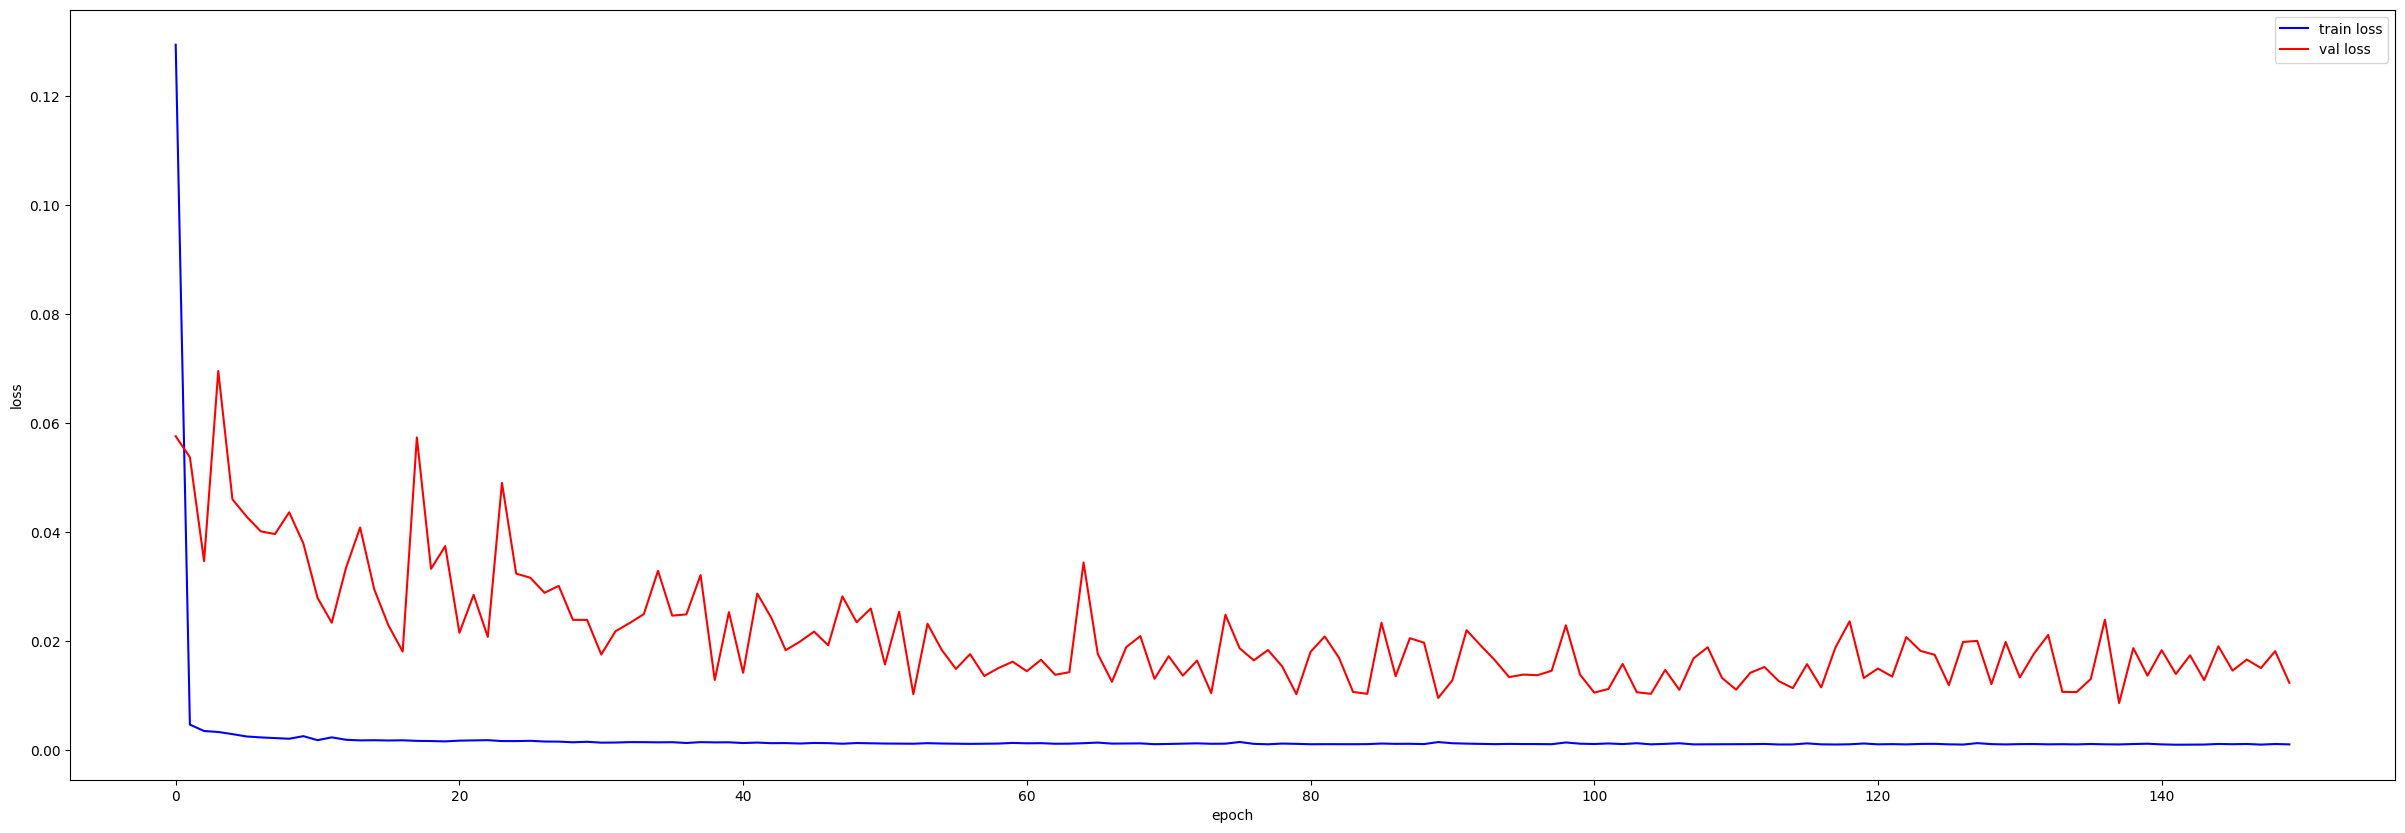

                           Close_lead1  Model forecast
Date                                                  
2023-01-03 00:00:00-05:00    88.709999       90.551224
2023-01-04 00:00:00-05:00    86.769997       90.015144
2023-01-05 00:00:00-05:00    88.160004       87.350113
2023-01-06 00:00:00-05:00    88.800003       87.312157
2023-01-09 00:00:00-05:00    89.239998       89.326416
...                                ...             ...
2024-04-29 00:00:00-04:00   164.639999      161.532089
2024-04-30 00:00:00-04:00   165.570007      157.727524
2024-05-01 00:00:00-04:00   168.460007      158.808990
2024-05-02 00:00:00-04:00   168.990005      160.627243
2024-05-03 00:00:00-04:00   169.830002      160.658539

[336 rows x 2 columns]
MASE = 1.7870938755376844
RMSE = 3.370092782869834
SMAPE = 2.017925841031078
MAE = 2.534341948372977
sharp_ratio = -0.06309633507334898


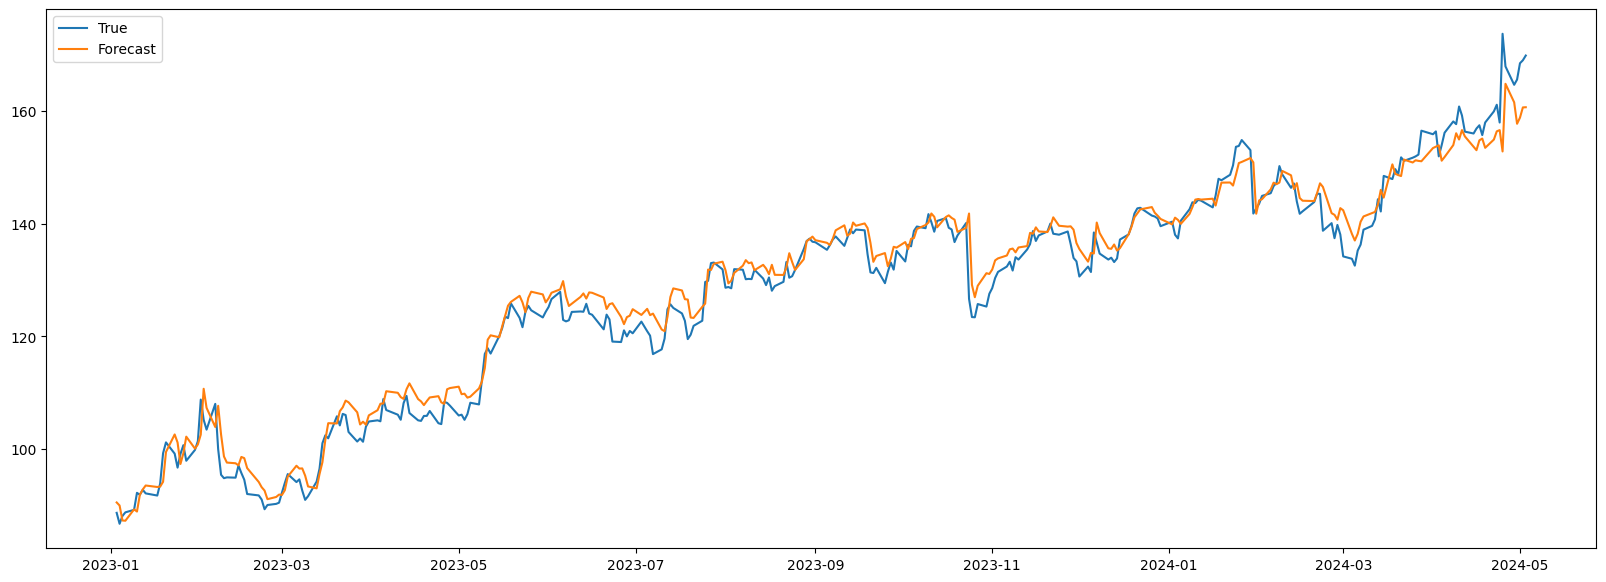

In [270]:
param_grid = copy_from_best(best_params)
param_grid['num_consecutive_days'] = [30, 60, 90]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

  0%|          | 0/4 [00:00<?, ?it/s]

(0.2, 1e-05, 0.001, 16, 1, 64, 3, False, 30, 1, 16, 32)
Epoch 0
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.6181437251350236
Test loss: 1.085366951301694
Save new best model

Epoch 1
---------
Train loss: 0.13619789844822316
Test loss: 0.27129816450178623
Save new best model

Epoch 2
---------
Train loss: 0.029379228469989603
Test loss: 0.14757374115288258
Save new best model

Epoch 3
---------
Train loss: 0.009040531040804963
Test loss: 0.10213564848527312
Save new best model

Epoch 4
---------
Train loss: 0.005356318834755156
Test loss: 0.03611595195252448
Save new best model

Epoch 5
---------
Train loss: 0.003824360713007904
Test loss: 0.04756662074942142

Epoch 6
---------
Train loss: 0.0032614205708904635
Test loss: 0.04077664285432547

Epoch 7
---------
Train loss: 0.002959367041180413
Test loss: 0.029390652780421078
Save new best model

Epoch 8
---------
Train loss: 0.0029599484858206576
Test loss: 0.027105727815069258
Save new best model

Epoch 9
---------
Train loss: 0.0028500695535469624
Test loss: 0.021906952955760062
Save new best model

Epoch 10
---------
Train lo

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.31728138337059625
Test loss: 0.16819503693841398

Epoch 1
---------
Train loss: 0.03719875743494384
Test loss: 0.035278477938845754

Epoch 2
---------
Train loss: 0.0054380035412216945
Test loss: 0.1108262687921524

Epoch 3
---------
Train loss: 0.003636441030909145
Test loss: 0.0392788746394217

Epoch 4
---------
Train loss: 0.0031324964855605412
Test loss: 0.049238638021051884

Epoch 5
---------
Train loss: 0.0027227555438580496
Test loss: 0.04267425974830985

Epoch 6
---------
Train loss: 0.0026651128261749235
Test loss: 0.02831771457567811

Epoch 7
---------
Train loss: 0.002390942019816961
Test loss: 0.039233068469911814

Epoch 8
---------
Train loss: 0.0024353049396138105
Test loss: 0.04760543815791607

Epoch 9
---------
Train loss: 0.002250979759819096
Test loss: 0.041429424891248345

Epoch 10
---------
Train loss: 0.0020606038280733168
Test loss: 0.04594985628500581

Epoch 11
---------
Train loss: 0.002018095666287644
Test loss: 0.03030155971646309

Epoch 12
-----

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.21141054674923893
Test loss: 0.021217733738012612

Epoch 1
---------
Train loss: 0.007157798331703932
Test loss: 0.033423959743231535

Epoch 2
---------
Train loss: 0.0038969648229549565
Test loss: 0.05751743959262967

Epoch 3
---------
Train loss: 0.003503208360930402
Test loss: 0.09441517386585474

Epoch 4
---------
Train loss: 0.002978135995189881
Test loss: 0.05754172708839178

Epoch 5
---------
Train loss: 0.002758656933327161
Test loss: 0.034092840272933245

Epoch 6
---------
Train loss: 0.0025916112159999707
Test loss: 0.049576712073758245

Epoch 7
---------
Train loss: 0.0024383592868356834
Test loss: 0.05966462567448616

Epoch 8
---------
Train loss: 0.0021435599986626397
Test loss: 0.038154584472067654

Epoch 9
---------
Train loss: 0.0020912917615431878
Test loss: 0.0785335274413228

Epoch 10
---------
Train loss: 0.0027629494489658448
Test loss: 0.03113871393725276

Epoch 11
---------
Train loss: 0.001989890987585698
Test loss: 0.045544569147750735

Epoch 12
-

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.12884884757093257
Test loss: 0.06968037388287485

Epoch 1
---------
Train loss: 0.0048703771003241105
Test loss: 0.09877332765609026

Epoch 2
---------
Train loss: 0.003752563466569261
Test loss: 0.17610483895987272

Epoch 3
---------
Train loss: 0.003497438823124246
Test loss: 0.08564674621447921

Epoch 4
---------
Train loss: 0.003069899435753801
Test loss: 0.06231211149133742

Epoch 5
---------
Train loss: 0.002716136935521804
Test loss: 0.07581556215882301

Epoch 6
---------
Train loss: 0.002452900156467443
Test loss: 0.09003197867423296

Epoch 7
---------
Train loss: 0.0021319843279863043
Test loss: 0.09008008847013116

Epoch 8
---------
Train loss: 0.002411428500809485
Test loss: 0.09489866439253092

Epoch 9
---------
Train loss: 0.0021081432535697427
Test loss: 0.03465095767751336

Epoch 10
---------
Train loss: 0.0019712683556246616
Test loss: 0.04696829221211374

Epoch 11
---------
Train loss: 0.002459037355110345
Test loss: 0.026522394618950784

Epoch 12
-------

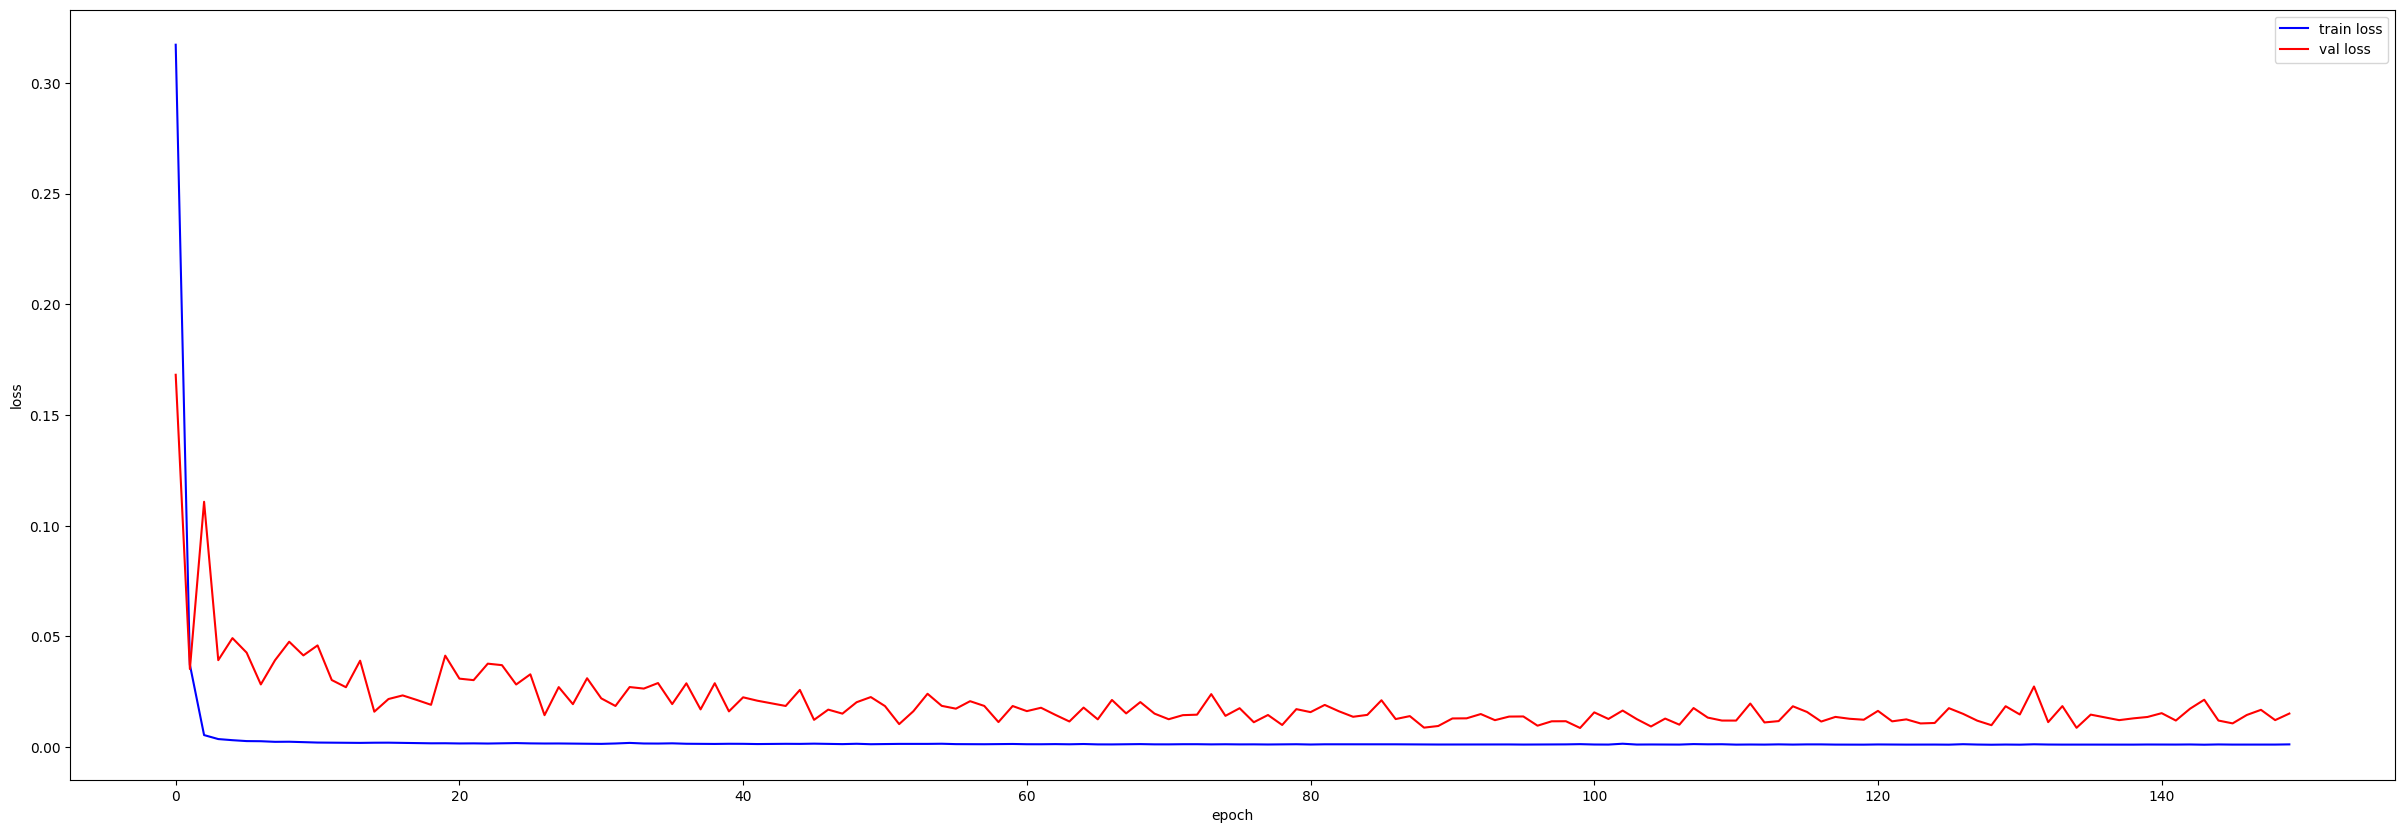

                           Close_lead1  Model forecast
Date                                                  
2023-01-03 00:00:00-05:00    88.709999       91.749405
2023-01-04 00:00:00-05:00    86.769997       91.281357
2023-01-05 00:00:00-05:00    88.160004       88.659866
2023-01-06 00:00:00-05:00    88.800003       89.152710
2023-01-09 00:00:00-05:00    89.239998       90.881615
...                                ...             ...
2024-04-29 00:00:00-04:00   164.639999      159.781723
2024-04-30 00:00:00-04:00   165.570007      158.091736
2024-05-01 00:00:00-04:00   168.460007      158.691727
2024-05-02 00:00:00-04:00   168.990005      159.502274
2024-05-03 00:00:00-04:00   169.830002      159.222046

[336 rows x 2 columns]
MASE = 2.264393582676572
RMSE = 3.9639094795598324
SMAPE = 2.50624501394683
MAE = 3.166695231483096
sharp_ratio = -0.09831617598219007


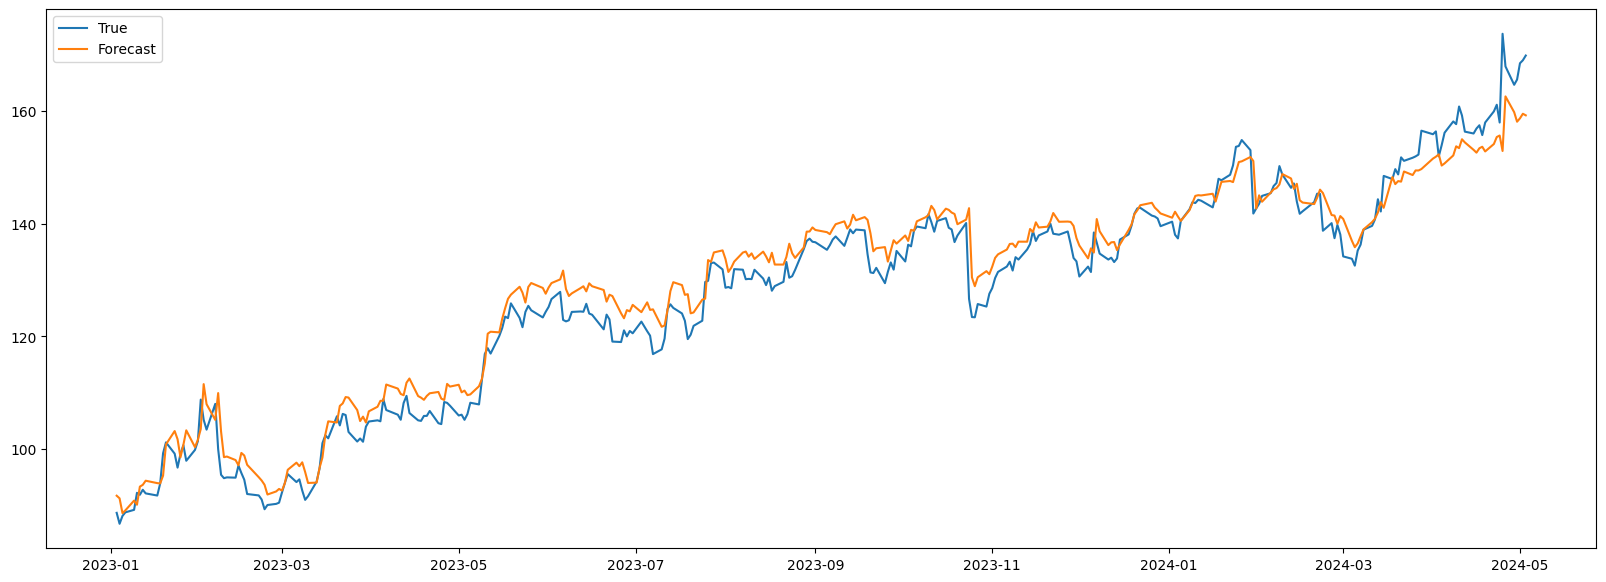

In [271]:
param_grid = copy_from_best(best_params)
param_grid['num_lstm_hiddensize'] = [16, 32, 64, 128]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

In [ ]:
param_grid = copy_from_best(best_params)
param_grid['lstm_layers'] = [1, 3, 5]
param_grid['dropout_lstm'] = [0.0, 0.2]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

  0%|          | 0/6 [00:00<?, ?it/s]

(0.0, 1e-05, 0.001, 32, 1, 64, 3, False, 30, 1, 16, 32)
Epoch 0
---------
Train loss: 0.19754947795872652
Test loss: 0.08559920778498054
Save new best model

Epoch 1
---------
Train loss: 0.009821059950996958
Test loss: 0.2750027682632208

Epoch 2
---------
Train loss: 0.0036452553486303677
Test loss: 0.18899897346273065

Epoch 3
---------
Train loss: 0.0029653694909361618
Test loss: 0.16560027189552784

Epoch 4
---------
Train loss: 0.0026951192098388834
Test loss: 0.14796837884932756

Epoch 5
---------
Train loss: 0.0025566833625946727
Test loss: 0.17889763321727514

Epoch 6
---------
Train loss: 0.0023246492002351534
Test loss: 0.16062255017459393

Epoch 7
---------
Train loss: 0.0022037613329418475
Test loss: 0.1604029699228704

Epoch 8
---------
Train loss: 0.0023183887556476133
Test loss: 0.137750294059515

Epoch 9
---------
Train loss: 0.0020548812259683414
Test loss: 0.0876940106973052

Epoch 10
---------
Train loss: 0.002126744466035494
Test loss: 0.10312924860045314

Epoch 11

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.2823430047858329
Test loss: 0.10694171744398773

Epoch 1
---------
Train loss: 0.017630020385637643
Test loss: 0.3136191335506737

Epoch 2
---------
Train loss: 0.004532640907056038
Test loss: 0.2802019929513335

Epoch 3
---------
Train loss: 0.0042111118349971045
Test loss: 0.23076080810278654

Epoch 4
---------
Train loss: 0.0035553780598713766
Test loss: 0.258942318148911

Epoch 5
---------
Train loss: 0.003253573398401458
Test loss: 0.16724190209060907

Epoch 6
---------
Train loss: 0.003036200292482381
Test loss: 0.15693095047026873

Epoch 7
---------
Train loss: 0.0027346602892355312
Test loss: 0.16971543245017529

Epoch 8
---------
Train loss: 0.0025409948134366128
Test loss: 0.12233435967937112

Epoch 9
---------
Train loss: 0.002484199918052625
Test loss: 0.11829461064189672

Epoch 10
---------
Train loss: 0.0023425065012397392
Test loss: 0.09036450460553169

Epoch 11
---------
Train loss: 0.0023082787437098367
Test loss: 0.07689571613445878

Epoch 12
---------
T